# <a id='toc1_'></a>[Quantization and stemming of music language through Gaussian Mixture Models](#toc0_)

Author: Piero Birello, <birello_piero@phd.ceu.edu>

Date: November 2024

Outline: What are the basic constituents of music?

Quantization is the task of providing a compact, discrete representation of a large and possibly continuous set of elements, while preserving enough information to allow high reconstruction quality. The aim of this short project is to explore a method for quantization of music language (audio files). 

Our starting point will be the GTZAN dataset (a.k.a. the MNIST of sound), containing a large number of music audio files belonging to different genres. We will convert audio files to spectrograms. We will extract from spectrograms our effective dataset, i.e., a collection of a large number of spectrogram instances. Spectrogram instances represent the amplitude of different frequencies recorded at a given time. As we will see, spectrograms exhibit so much variability that repeated instances are rarely encountered. An enlarged dataset wouldn't likely change this result. Our question will then be, can we find a representative subsample in the sample of all spectrogram instances? 

We reformulate the problem as a clustering problem. First, we perform PCA to reduce the dimensionality of our samples. We actually find a large number of features to be irrelevant. We then cluster them using Gaussian Mixture Models, and select the optimal number of clusters according to the BIC criterium, finding an optimal balance in the tradeoff between model likelyhood and number of parameters when choosing 300 clusters. The means of each cluster can be thought of as basic spectrogram instances. Instances in a same cluster may be thought of as inflections of the representative instance, i.e., we have performed stemming as well.

At last, we briefly observe the distribution of occurrencies of the found clusters in different music genres, and compare them. Unsurprisingly, classical music and metal seem to be the most unsimilar couple.

**Table of contents**<a id='toc0_'></a>    
- [Quantization and stemming of music language through non-parametric clustering and MDL principle](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Download and load data](#toc1_2_)    
  - [Audio files exploratory analysis](#toc1_3_)    
  - [Obtain collection of spectrogram instances](#toc1_4_)    
  - [PCA](#toc1_5_)    
  - [Clustering](#toc1_6_)    
  - [How do genres differ?](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from tqdm import tqdm
import random
import IPython.display as ipd
import librosa
import librosa.display
import pickle
import joblib

from  sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.mixture import GaussianMixture
from collections import Counter
import scipy
import itertools

In [64]:
# Be kind to other people on the server
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

## <a id='toc1_2_'></a>[Download and load data](#toc0_)

The GTZAN dataset for music genre classification can be dowloaded from Kaggle. See the following [link](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification) for a description of the dataset. 

In [2]:
# Download the dataset from Kaggle and extract zip content

import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [3]:
# Extract all the contents of zip file in different directory

from zipfile import ZipFile

dirname = "Data/"

if not os.path.isdir(dirname):
    with ZipFile(fname, 'r') as zipObj:
        zipObj.extractall()

os.listdir(dirname)

['images_original',
 'genres_original',
 'features_3_sec.csv',
 'features_30_sec.csv']

## <a id='toc1_3_'></a>[Audio files exploratory analysis](#toc0_)

Using directly images of spectrograms requires interpolation of RGBA-valued cells to retrieve the intensity of frequencies at a given time stamp. Results using this methodology were not satisfying. I will use audio files instead. This section is a stand-alone one, and not necessary to the final aim. Here we just see how to treat an example audio file and obtain spectrograms of two types.

In [4]:
# genres_original contains audio files

genres_dirs = os.listdir(f"{dirname}genres_original")
print(f"There are {len(genres_dirs)} genres:", genres_dirs)
genres_nfiles = [len(os.listdir(f"{dirname}genres_original/{g}")) for g in genres_dirs]
print(f"They contain {genres_nfiles} .wav files respectively")

print("\nHere's an example:")
sample_audio_path = f"{dirname}genres_original/blues/" + random.choice(os.listdir(f"{dirname}genres_original/blues/"))
print(sample_audio_path,'\n')

# Display Audio
sample_audio = ipd.Audio(sample_audio_path)
sample_audio

There are 10 genres: ['jazz', 'metal', 'country', 'pop', 'blues', 'disco', 'classical', 'hiphop', 'reggae', 'rock']
They contain [100, 100, 100, 100, 100, 100, 100, 100, 100, 100] .wav files respectively

Here's an example:
Data/genres_original/blues/blues.00003.wav 



In [5]:
# Extract audio array and sample rate
y, sr = librosa.core.load(sample_audio_path)
print('y:', y)
print('y shape:', np.shape(y))
print('Sample rate (KHz):', sr)
print(f'Length of audio: {np.shape(y)[0]/sr}','\n')

y: [-0.01300049 -0.03060913 -0.03607178 ...  0.0098877   0.01107788
  0.0118103 ]
y shape: (661794,)
Sample rate (KHz): 22050
Length of audio: 30.013333333333332 



In [6]:
# Convert audio to decibel-scaled spectrogram through short-time Fourier transform (STFT).
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of the decibel-scaled spectrogram:',D.shape)
# Rescale amplitude to decibels
DB = librosa.amplitude_to_db(D, ref = np.max)

# Convert audio to Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
print('Shape of the Mel spectrogram:',S.shape)
# Rescale amplitude to decibels
S_DB = librosa.amplitude_to_db(S, ref=np.max)

Shape of the decibel-scaled spectrogram: (1025, 1293)
Shape of the Mel spectrogram: (128, 1293)


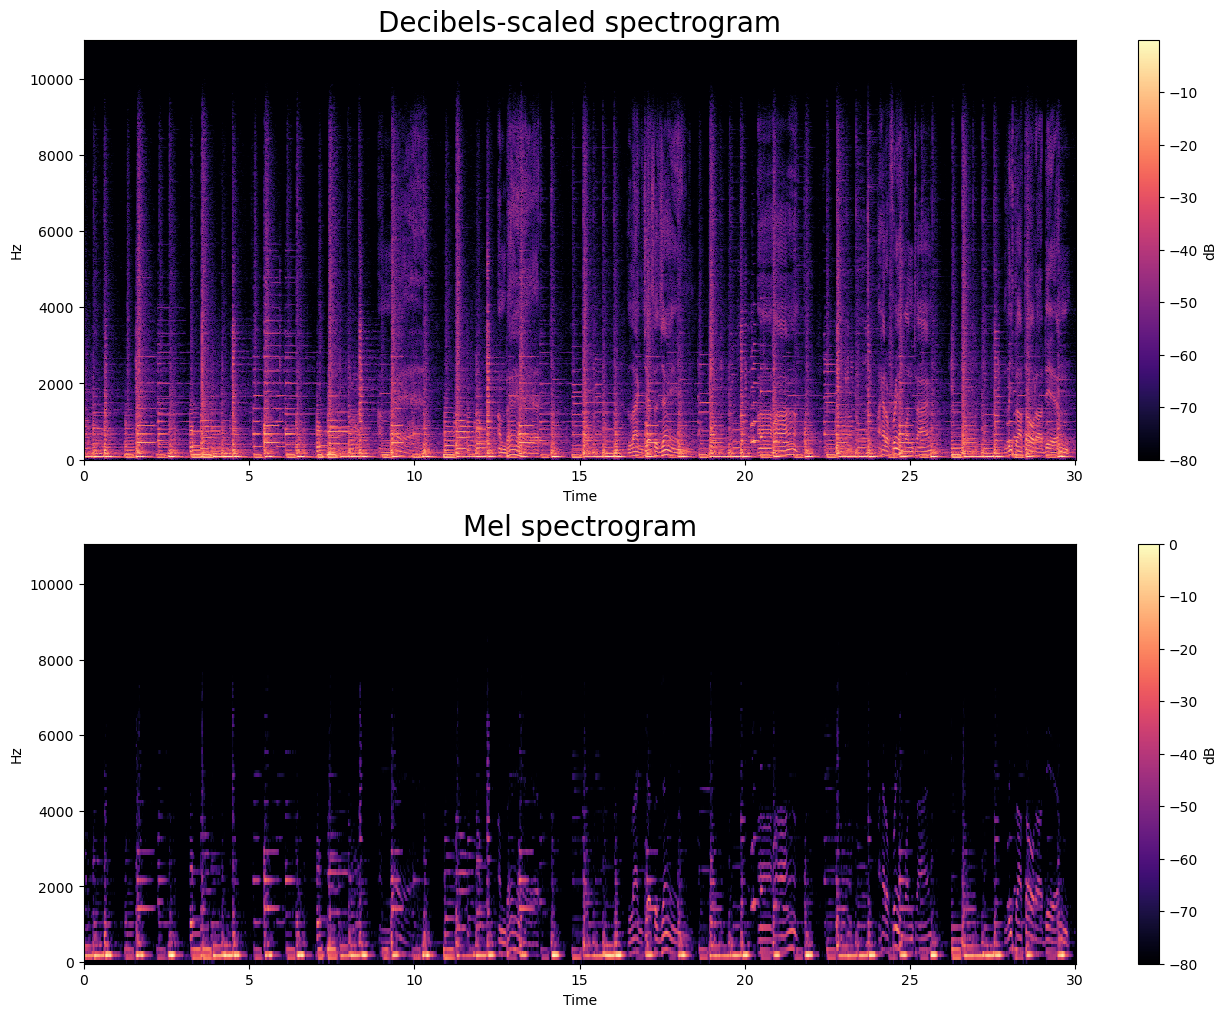

In [8]:
# Fig
fig,axes = plt.subplots(2,1,figsize=(16,12))

# Plot decibel scaled spec
spec_0 = librosa.display.specshow(DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='hz', ax=axes[0])
cbar_0 = plt.colorbar(spec_0)
cbar_0.set_label('dB')
axes[0].set_title('Decibels-scaled spectrogram', fontsize=20)

# Plot Mel spec
spec_1 = librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='hz', ax=axes[1])
cbar_1 = plt.colorbar(spec_1)
cbar_1.set_label('dB')
axes[1].set_title("Mel spectrogram", fontsize=20)


plt.savefig('Ex_spectrogram.pdf')
plt.show()

## <a id='toc1_4_'></a>[Obtain collection of spectrogram instances](#toc0_)

Here we collect our dataset of spectrogram instances running the operations we just showed on all files available.

In [9]:
# Define a single function to process audio files
def audio_path_to_spec(audio_path, spec_type='ds'):
    y, sr = librosa.core.load(audio_path)
    if spec_type == 'ds':
        D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    elif spec_type == 'mel':
        D = librosa.feature.melspectrogram(y=y, sr=sr)
    DB = librosa.amplitude_to_db(D, ref = np.max)
    return DB

# Iterate over all files and collect instances
def data_collector(spec_type='ds'):
    data_dic = {}
    filesdir = "Data/genres_original"
    genres_dirs = os.listdir(filesdir)
    for g in tqdm(genres_dirs):
        data_list = []
        for file in os.listdir(f"{filesdir}/{g}/"):
            if file.endswith('.wav'):
                try:
                    DB = audio_path_to_spec(f"{filesdir}/{g}/{file}",
                                            spec_type=spec_type)
                    instances = DB.T
                    data_list.append(instances)
                except Exception as e:
                    print(e)
        data_dic[g] = np.concatenate(data_list,axis=0)           
    DATASET = np.concatenate(list(data_dic.values()),axis=0)
    return DATASET, data_dic

DATASET_ds, data_dic_ds = data_collector(spec_type='ds')
print(DATASET_ds.shape)

DATASET_mel, data_dic_mel = data_collector(spec_type='mel')
print(DATASET_mel.shape)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_19073/2434283715.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.core.load(audio_path)
/mnt/sdb1/pbirello/miniconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


(1292334, 1025)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


(1292334, 128)


We consider the whole dataset for analysis. Dataset by genre is stored for later use.

In [10]:
# Keep only unique instances

org_ds_shape = DATASET_ds.shape[0]
DATASET_ds = np.unique(DATASET_ds,axis=0)
ds_shape = DATASET_ds.shape[0]
print(f"{ds_shape/org_ds_shape*100}% of the ds instances are unique")

org_mel_shape = DATASET_mel.shape[0]
DATASET_mel = np.unique(DATASET_mel,axis=0)
mel_shape = DATASET_mel.shape[0]
print(f"{mel_shape/org_mel_shape*100}% of the mel instances are unique")

98.47609054625197% of the ds instances are unique
98.26879119484592% of the mel instances are unique


## <a id='toc1_5_'></a>[PCA](#toc0_)

Let's perform principal component analysis. In the plot, we show the explained varaince ratio of principal components. Also, we visualize the first principal component in original coordinates. This gives us an idea of how the axis explaining the highest varaince would look in a spectrogram. The same colormap as in above spectrogram is used, even if redudant (simply codes y axis value).

D-S completed
Mel completed


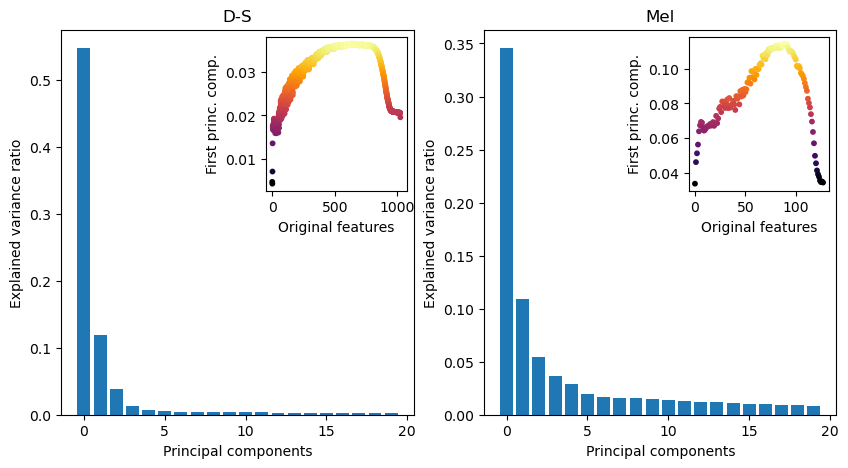

In [ ]:
# PCA

fig,axes=plt.subplots(1,2,figsize=(10,5))
titles = ['D-S','Mel']
scaler_dic = {}
pca_dic = {}
principal_components_dic = {}

for i,(ax,data_) in enumerate(zip(axes,[DATASET_ds,DATASET_mel])):

    data = data_.copy()#[::10000]

    # Standardize features (frequencies)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaler_dic[titles[i]] = scaler

    # PCA
    pca = PCA()
    principal_components = pca.fit_transform(scaled_data)
    pca_dic[titles[i]] = pca
    principal_components_dic[titles[i]] = principal_components

    # Plot bar
    ax.bar(np.arange(20),pca.explained_variance_ratio_[:20])
    ax.set_xlabel('Principal components')
    ax.set_ylabel('Explained variance ratio')
    ax.set_title(titles[i])

    # Plot first princ. comp. in inset
    inset_ax = inset_axes(ax, width='40%', height='40%', loc='upper right')
    inset_ax.scatter(np.arange(pca.components_.shape[1]),pca.components_[0],s=10,
            c=pca.components_[0],cmap='inferno')
    inset_ax.set_xlabel('Original features')
    inset_ax.set_ylabel('First princ. comp.')

    print(f'{titles[i]} completed')

plt.savefig('PCA_DS_Mel.pdf')

Since the decibel-scaled spectrogram seems to be redundant, we will work on mel spectrograms from now on.

In [ ]:
# Keep only relevant data
scaler = scaler_dic['Mel']
pca = pca_dic['Mel']
principal_components = principal_components_dic['Mel']

del scaler_dic
del pca_dic
del principal_components_dic

In [ ]:
# Maintain only most relevant features
org_shape = principal_components.shape
component_95var = np.where(np.cumsum(pca.explained_variance_ratio_)>.95)[0][0]
pc_95 = principal_components[:,:component_95var+1]
reduced_shape = pc_95.shape
print('Shape:',org_shape,'-->',reduced_shape)

# Again, check uniqueness
pc_95 = np.unique(pc_95,axis=0)
print(f"{np.unique(pc_95,axis=0).shape[0]/org_shape[0]*100}% of the instances are unique")

Shape: (1269961, 128) --> (1269961, 71)
100.0% of the instances are unique


In [ ]:
# Save checkpoint
pca_checkpoint = {'scaler':scaler,'pca':pca,'component_95var':component_95var,'pc_95':pc_95}
joblib.dump(pca_checkpoint,'interim/pca_checkpoint.pkl',compress=True)

['interim/pca_checkpoint.pkl']

## <a id='toc1_6_'></a>[Clustering](#toc0_)

We use Gaussian Mixtures to cluster spectrogram instances. In particular, we are interested in selecting an optimal number of clusters. Non-parametric extensions of Gaussian Mixtures using variational Bayesian estimation exist, and are also implemented in [sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.mixture.BayesianGaussianMixture.html). However, the large size of our dataset makes their computational time very long. We will instead adopt a non fully Bayesian approach, evaluating Gaussian Mixtures with given number of components, and then comparing their AIC and BIC scores. Let $k$ be the number of parameters of a model, $\hat{L}$ the maximized value of the likelyhood of the model, $n$ the sample size. Then:

$AIC = 2k -2 ln(\hat{L})$

$BIC = ln(n)k -2 ln(\hat{L})$

Note that BIC represents an approximation of the marginal likelyhood of data given a selected model, and penalizes models with more parameters, even though they can usually fit the data more closely.

In [11]:
# Load
pca_checkpoint = joblib.load('interim/pca_checkpoint.pkl')
scaler, pca, component_95var, pc_95 = pca_checkpoint['scaler'], pca_checkpoint['pca'], pca_checkpoint['component_95var'], pca_checkpoint['pc_95']

In [19]:
# Define values to explore
n_components = [1,2,10,25,50,100,200,300,400,500,600]

In [ ]:
# Define empty lists
bic_list, aic_list = [], []
gmm_list = []
subset = pc_95.copy()#[::10] 

# Iterate over number of components
for n in tqdm(n_components):
    gmm = GaussianMixture(
        n_components=n, tol=1e0, max_iter=50, n_init = 2
        ).fit(subset)
    gmm_list.append(gmm)
    bic = gmm.bic(subset)
    aic = gmm.aic(subset)
    bic_list.append(bic)
    aic_list.append(aic)

    # Save current state after each iteration
    joblib.dump({'gmm_list':gmm_list,'bic_list':bic_list,'aic_list':aic_list},
                'interim/gmm_checkpoint.pkl',compress=True)

100%|██████████| 2/2 [19:20:41<00:00, 34820.87s/it] 


In [ ]:
# Load
gmm_checkpoint = joblib.load('interim/gmm_checkpoint.pkl')
gmm_list, bic_list, aic_list = gmm_checkpoint['gmm_list'], gmm_checkpoint['bic_list'], gmm_checkpoint['aic_list']

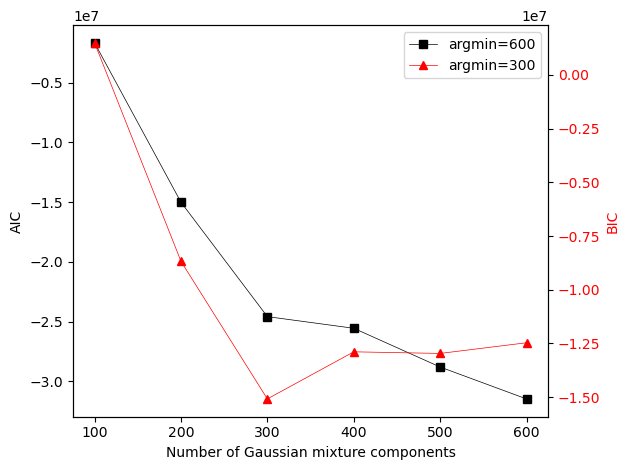

In [ ]:
start_index = 5 # Index from which to plot

# Plot
fig,ax = plt.subplots()

x = np.arange(len(n_components))
argmin_aic = n_components[np.argmin(aic_list)]
argmin_bic = n_components[np.argmin(bic_list)]

# aic on ax
ax.plot(x[start_index:],aic_list[start_index:],color='k',marker='s',linewidth=.5,label=f'argmin={argmin_aic}')
ax.set_ylabel('AIC')

# bic on ax_
ax_ = ax.twinx()
ax_.plot(x[start_index:],bic_list[start_index:],color='r',marker='^',linewidth=.5,label=f'argmin={argmin_bic}')
ax.plot([],[],color='r',marker='^',linewidth=.5,label=f'argmin={argmin_bic}')
ax_.set_ylabel('BIC',color='r')
for label in ax_.get_yticklabels():
    label.set_color('red')

# Adjust xticks
ax.set_xticks(x[start_index:])
ax.set_xticklabels(n_components[start_index:])
ax.set_xlabel('Number of Gaussian mixture components')

# Legend, layout, save
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('AIC_BIC.pdf')

In [ ]:
# Chosen number of components
argmin = np.argmin(bic_list)
chosen_components = n_components[argmin]
print(chosen_components)

# Keep only relevant data
gmm = gmm_list[argmin]
del gmm_list, aic_list, bic_list

300


In [28]:
# Save model
joblib.dump(gmm,'interim/gmm.pkl',compress=True)

['interim/gmm.pkl']

## <a id='toc1_7_'></a>[How do genres differ?](#toc0_)

Are the found cluters differently represented in music genres?

In [ ]:
# Load model
gmm = joblib.load('interim/gmm.pkl')

In [ ]:
# Predict cluster assignments
filesdir = "Data/genres_original"
genres_dirs = os.listdir(filesdir)
Y = {}

for g in tqdm(genres_dirs):
    data_processed = pca.transform(scaler.transform(data_dic_mel[g]))[:,:component_95var+1]
    y = gmm.predict(data_processed)
    Y[g] = y

100%|██████████| 10/10 [07:48<00:00, 46.85s/it]


In [ ]:
# Compute Chi-Square Test
X2 = pd.DataFrame(index=genres_dirs, columns=genres_dirs,dtype='float')
p_val = X2.copy()

for g1,g2 in tqdm(itertools.combinations(genres_dirs,2)):

    # Counter
    c1 = Counter(Y[g1])
    c2 = Counter(Y[g2])
    
    # Get the union of all unique categories
    categories = list(set(c1.keys()).union(set(c2.keys())))

    # Create observed frequency table
    observed = [[c1.get(cat, 0), c2.get(cat, 0)] for cat in categories]

    # Compute test
    chi2, p_value, _, _ = scipy.stats.chi2_contingency(observed)

    # Store vals
    X2.loc[g1,g2] = chi2
    p_val.loc[g1,g2] = p_value

45it [00:02, 17.66it/s]


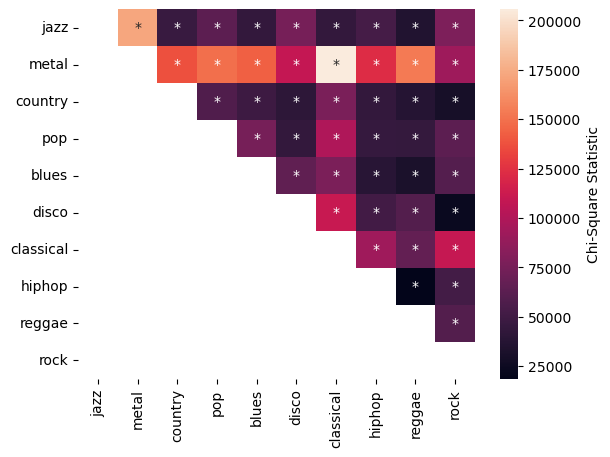

In [103]:
# Plot heatmap
fig,ax = plt.subplots()
heatmap = sns.heatmap(X2, mask=np.tril(np.ones(X2.shape)), 
            annot=p_val.map(lambda x: '*' if x<0.05 else ''), 
            fmt='',ax=ax, cbar_kws={'label': 'Chi-Square Statistic'})

Classical music and metal don't get along well. All differences are significant.